# **Uczenie Maszynowe - LAB03 - LIME**

Przygotowali: Arkadiusz Pajor i Michał Sokół

Ten notebook jest wprowadzeniem w zagadnienie Interpretowalnego Uczenia Aktywnego (ang. Interpretable Active Learning).

Slajdy z prezentacji znajdują się w załączonych materiałach.

Biblioteka LIME: https://github.com/marcotcr/lime (Dokumentacja API: https://lime-ml.readthedocs.io/en/latest/)

# **Wprowadzenie - pakiety**

Niezbędne pakiety i moduły na potrzeby wprowadzenia

In [ ]:
pip install lime

In [ ]:
import json
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries
from torchvision import models, transforms

# Wprowadzenie - funkcje pomocnicze

Funkcja do wczytywania wskazanego obrazka oraz konwersji do palety RGB.

In [ ]:
def get_image(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

Funkcja do przekształcania obrazka (zwróconego przez funkcję `get_image`) w tensor, akceptowalny na wejściu sieci neronowej.

In [ ]:
def image_to_tensor(img):    
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])  
    return transformer(img).unsqueeze(0)

Funkcja używana przez LIME, przyjmuje na wejściu zbiór obrazków, a zwraca prawdopodobieństwa klas. Należy ją przekazać do `lime_image.LimeImageExplainer().explain_instance` przy użyciu `partial`, jako `partial(predict_batch, <model>)`, gdzie modelem w naszym wypadku będą sieci neuronowe. Przykłady użycia są zawarte w tym notebooku.

In [ ]:
def predict_batch(model, images):
    model.eval()
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]) 
    ])   
    
    model.eval()
    batch = torch.stack(tuple(transformer(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probas = torch.nn.functional.softmax(logits, dim=1)
    return probas.detach().cpu().numpy()

Funkcja, która przekształca obrazek w format akceptowany na wejściu przez LIME. Przykłady użycia są zawarte w tym notebooku.

In [ ]:
def lime_transformer(image):
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])
    return np.array(transformer(image))

LIME jest głównie wykorzystywane do **wyjaśniania** predykcji tzw. czarnych skrzynek, czyli modeli nieinterpretowalnych. Idealnymi kandydatami są Głębokie Sieci Neuronowe, dlatego spróbujemy wyjaśnić niektóre predykcje gotowych modeli.

# **Model Inception-v3 - przygotowanie danych**
https://arxiv.org/abs/1512.00567

Plik `./data/imagenet_class_index.json` zawiera przypisanie klas obrazków do indeksów. Jest to istotne, ponieważ zwracane wyniki (np. wartości funkcji logit na wyjściu sieci neuronowych) wykorzystują to, zwracając wyniki w zadanej kolejności.

In [ ]:
with open("./data/imagenet_class_index.json") as f:
    content = json.load(f)
    index_to_label = {
        int(index): data[1]
        for index, data in content.items()
    }

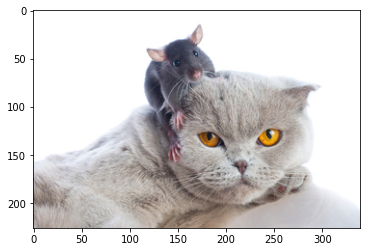

In [ ]:
image_to_classify = get_image("./data/cat_mouse.jpeg")
plt.imshow(image_to_classify)

In [ ]:
img_tensor = image_to_tensor(image_to_classify)

### **Załadowanie pretrenowanego modelu**

In [ ]:
inception_v3 = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

### **Predykcja**

In [ ]:
inception_v3.eval()
logits = inception_v3(img_tensor)

Zwróć uwagę, że model zwraca wartości funkcji logit, a nie prawdopodobieństwa klas, dlatego wyniki trzeba przetworzyć (np. przy użyciu funkcji softmax).

In [ ]:
probas = torch.nn.functional.softmax(logits, dim=1)

Sprawdźmy N najbardziej prawdopodobnych klas

In [ ]:
TOP_N_LABELS = 15

probas_top = probas.topk(TOP_N_LABELS)
top_probas = probas_top[0][0].detach().numpy()
top_labels = probas_top[1][0].detach().numpy()
for proba, label in zip(top_probas, top_labels):
    print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

Class: Egyptian_cat                   | Probability: 0.967492
Class: tabby                          | Probability: 0.024167
Class: lynx                           | Probability: 0.005490
Class: tiger_cat                      | Probability: 0.002165
Class: Persian_cat                    | Probability: 0.000105
Class: Angora                         | Probability: 0.000074
Class: swab                           | Probability: 0.000071
Class: Madagascar_cat                 | Probability: 0.000064
Class: snow_leopard                   | Probability: 0.000040
Class: tile_roof                      | Probability: 0.000037
Class: indri                          | Probability: 0.000020
Class: leopard                        | Probability: 0.000016
Class: Siamese_cat                    | Probability: 0.000011
Class: ram                            | Probability: 0.000010
Class: crate                          | Probability: 0.000009


### **Teraz możemy te funkcje zebrać razem**

In [ ]:
def get_prediction_probabilities(image, model):
    img_tensor = image_to_tensor(image)
    model.eval()
    logits = model(img_tensor)
    probas = torch.nn.functional.softmax(logits, dim=1)
    
    TOP_N_LABELS = 15

    probas_top = probas.topk(TOP_N_LABELS)
    top_probas = probas_top[0][0].detach().numpy()
    top_labels = probas_top[1][0].detach().numpy()
    for proba, label in zip(top_probas, top_labels):
        print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

### **I sprawdzić jak ta predykcja wygląda dla innego obrazka**

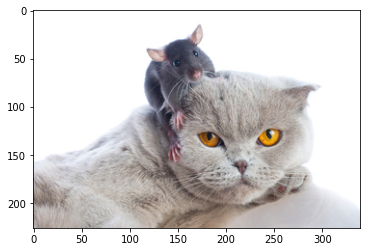

In [ ]:
exercise_image = get_image("./data/cat_mouse.jpeg")
plt.imshow(exercise_image)

## **Zadanie: sprawdź jak będzie wyglądała predykcja dla powyższego obrazka**

In [ ]:
get_prediction_probabilities(exercise_image, inception_v3)

Class: Egyptian_cat                   | Probability: 0.967492
Class: tabby                          | Probability: 0.024167
Class: lynx                           | Probability: 0.005490
Class: tiger_cat                      | Probability: 0.002165
Class: Persian_cat                    | Probability: 0.000105
Class: Angora                         | Probability: 0.000074
Class: swab                           | Probability: 0.000071
Class: Madagascar_cat                 | Probability: 0.000064
Class: snow_leopard                   | Probability: 0.000040
Class: tile_roof                      | Probability: 0.000037
Class: indri                          | Probability: 0.000020
Class: leopard                        | Probability: 0.000016
Class: Siamese_cat                    | Probability: 0.000011
Class: ram                            | Probability: 0.000010
Class: crate                          | Probability: 0.000009


# **Model Inception-v3 - wyjaśnienie**

Chcemy wiedzieć dlaczego klasa `Bernese_mountain_dog` została uznana przez sieć neuronową za najbardziej prawdopodobną (to znaczy - które piksele obrazka o tym zadecydowały). W tym celu właśnie wykorzystamy LIME.

W jaki sposób działa LIME na obrazkach?
1. Na wejściu wymagany jest oryginalny obrazek.
2. Wejściowy obrazek jest delikatnie przekształcany wiele razy, dzięki czemu otrzymujemy wiele podobnych (ale nie takich samych!) obrazków.
3. Dodatkowo na wejście musimy podać funkcję, która każdemu takiemu przekształceniu nada prawdopodobieństwo przynależności do danej klasy. Jest to wymagane ponieważ LIME jest niezależny od żadnych narzędzi i modeli.

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(
    image=lime_transformer(image_to_classify), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Mając te dane możemy teraz sprawdzić które kategorie są najbardziej prawdopodobne

In [ ]:
for index in explanation.top_labels:
    print(index_to_label[index])

Egyptian_cat
tabby
lynx
tiger_cat
Persian_cat


Zobaczmy co wpłynęło na wybranie `Bernese_mountain_dog` jako najbardziej prawdopodobnej klasy.

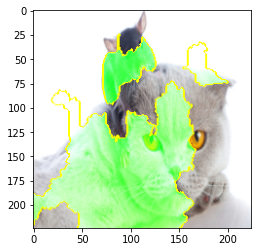

In [ ]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

## **Zadanie: zmień wartość NUM_FEATURES i zaobserwuj jak zmienia się mapowanie**
NUM_FEATURES najlepiej zmieniać w zakresie 1:50

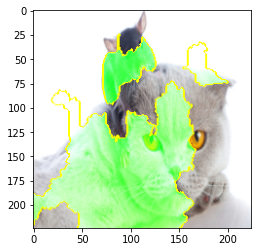

In [ ]:
NUM_FEATURES = 10

image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=NUM_FEATURES,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Zielone fragmenty oznaczają "superpiksele", które pozytywnie wpływają na predykowaną klasę. Czerwone fragmenty wpływają negatywnie.

## **Zadanie-pytanie: co to właściwie jest superpiksel?**
## **Zadanie-pytanie: czy jeden superpiksel ma odzwierciedlenie w jednym pikselu z obrazka?**

Zobaczmy jak to się prezentuje dla drugiej najbardziej prawdopodobnej klasy, czyli `EntleBucher`, która jednak otrzymała jedyne 3.8%.

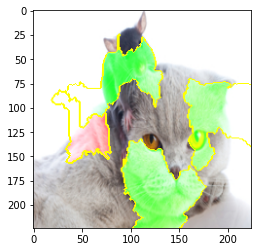

In [ ]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[1],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Ustawiając wartości `hide_rest` oraz `positive_only` na `True` jesteśmy w stanie zostawić tylko te piksele, które potwierdzały przynależność do danej klasy <br>
Musimy jednak pamiętać o przeskalowaniu rezultatu przy pomocy `(boundaries).astype(np.uint8)`

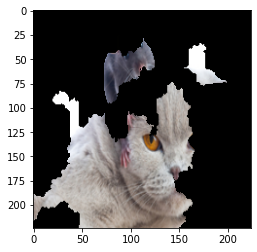

In [ ]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
plt.imshow((boundaries).astype(np.uint8))

Możemy również zostawić tylko te piksele, które zaprzeczały przynależności do danej klasy

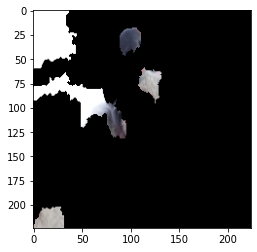

In [ ]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
cropped_image_ndarray = (boundaries).astype(np.uint8)
plt.imshow(cropped_image_ndarray)

A następnie sprawdzić co model sądzi o tak wyciętym obrazku

In [ ]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, inception_v3)

Class: groom                          | Probability: 0.819328
Class: bubble                         | Probability: 0.023892
Class: bonnet                         | Probability: 0.018004
Class: daisy                          | Probability: 0.015745
Class: feather_boa                    | Probability: 0.015059
Class: cauliflower                    | Probability: 0.012704
Class: hair_slide                     | Probability: 0.006953
Class: jellyfish                      | Probability: 0.004465
Class: banana                         | Probability: 0.004283
Class: rapeseed                       | Probability: 0.002980
Class: kimono                         | Probability: 0.002732
Class: picket_fence                   | Probability: 0.002382
Class: vase                           | Probability: 0.002139
Class: sulphur-crested_cockatoo       | Probability: 0.002000
Class: bald_eagle                     | Probability: 0.001988


I jak go teraz widzi model

In [ ]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

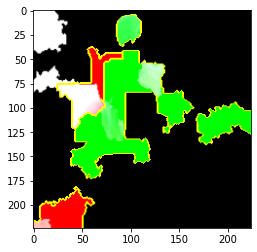

In [ ]:
image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

# **Model Inception-v3 - porównanie z AlexNet**

Przetestujmy działanie na innym modelu - `AlexNet`

In [ ]:
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
explanation_alexnet = explainer.explain_instance(
    image=lime_transformer(image_to_classify), 
    classifier_fn=partial(predict_batch, alexnet),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
for index_alex, index_inception in zip(explanation_alexnet.top_labels, explanation.top_labels):
    print(f"{index_to_label[index_alex]:30} | {index_to_label[index_inception]:30}")

Persian_cat                    | Egyptian_cat                  
Egyptian_cat                   | tabby                         
hamster                        | lynx                          
lynx                           | tiger_cat                     
tiger_cat                      | Persian_cat                   


Jak widać, klasy nieco się różnią, ale TOP 1 pozostaje takie samo.

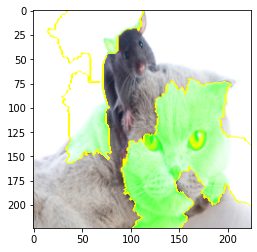

In [ ]:
image, mask = explanation_alexnet.get_image_and_mask(
    label=explanation_alexnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Wyjaśnienie dla `AlexNet` jak się można było spodziewać - też się różni, jednak w dalszym ciągu do klasyfikacji psa istotny jest... pies :)

## **Zadanie: porównaj predykcje obrazka dla modeli inception_v3 oraz alexnet**

In [ ]:
print("inception_v3")
get_prediction_probabilities(image_to_classify, inception_v3)
print()
print("alexnet")
get_prediction_probabilities(image_to_classify, alexnet)

inception_v3
Class: Egyptian_cat                   | Probability: 0.967492
Class: tabby                          | Probability: 0.024167
Class: lynx                           | Probability: 0.005490
Class: tiger_cat                      | Probability: 0.002165
Class: Persian_cat                    | Probability: 0.000105
Class: Angora                         | Probability: 0.000074
Class: swab                           | Probability: 0.000071
Class: Madagascar_cat                 | Probability: 0.000064
Class: snow_leopard                   | Probability: 0.000040
Class: tile_roof                      | Probability: 0.000037
Class: indri                          | Probability: 0.000020
Class: leopard                        | Probability: 0.000016
Class: Siamese_cat                    | Probability: 0.000011
Class: ram                            | Probability: 0.000010
Class: crate                          | Probability: 0.000009

alexnet
Class: Persian_cat                    | Probabil

# **Zadanie domowe - wstęp**
W folderze `data` znajduje się zdjęcie amfibii:
![title](data/amfibia.jpg)


In [ ]:
amphibious_vehicle = get_image("./data/amfibia.jpg")

  0%|          | 0/1000 [00:00<?, ?it/s]

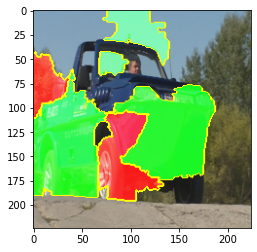

In [ ]:
inception_v3 = models.inception_v3(pretrained=True)

explanation_amhibious_vehicle_inception_v3 = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Model `inception_v3` jak i jego wyjaśnienie rzeczywiście sugerują amfibię jako najbardziej prawdopodobną klasę:

In [ ]:
for index in explanation_amhibious_vehicle_inception_v3.top_labels:
    print(index_to_label[index])

amphibian
convertible
racer
car_wheel
golfcart


# Zadanie domowe #1

Użyj dwóch różnych sieci neuronowych (poza inception_v3, którego przykład jest powyżej) do wygenerowania wyjaśnień.<br>
(skorzystaj z modułu torchvision: https://pytorch.org/vision/stable/models.html)

In [ ]:
beagle = amphibious_vehicle = get_image("./data/beagle4.jpg")

In [ ]:
densenet = models.densenet161(pretrained=True)
regnet_y_8gf = models.regnet_y_8gf(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/regnet_y_8gf-d0d0e4a8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_8gf-d0d0e4a8.pth


  0%|          | 0.00/151M [00:00<?, ?B/s]

In [ ]:
explanation_inception = explainer.explain_instance(
    image=lime_transformer(beagle), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
for index in explanation_inception.top_labels:
    print(index_to_label[index])

beagle
English_foxhound
Walker_hound
basset
basenji


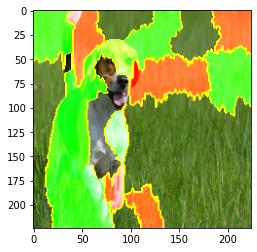

In [ ]:
image, mask = explanation_inception.get_image_and_mask(
    label=explanation_inception.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

In [ ]:
explanation_regnet = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle), 
    classifier_fn=partial(predict_batch, regnet_y_8gf),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
for index in explanation_regnet.top_labels:
    print(index_to_label[index])

beagle
English_foxhound
Walker_hound
basset
basenji


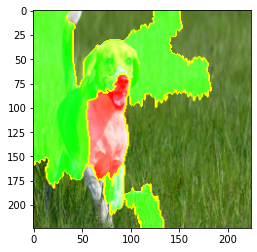

In [ ]:
image, mask = explanation_regnet.get_image_and_mask(
    label=explanation_regnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

# Zadanie domowe #2

Zmodyfikuj oryginalny obrazek w taki sposób, żeby najbardziej prawdopodobną klasą dla każdej z tych sieci **nie była** amfibia a jakiś inny pojazd (np. samochód). W tym celu możesz "zasłonić" czarnym kwadratem (wartość 0 w macierzy reprezentującej obraz) obszary istotne przy klasyfikacji. <br>
Przydatną rzeczą będzie skorzystanie z opcji `hide_rest` w funkcji `get_image_and_mask` i późniejsza obróbka obrazu

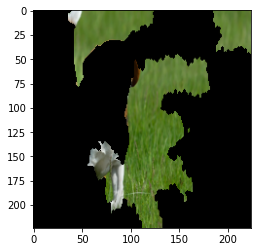

In [ ]:
image, mask = explanation_inception.get_image_and_mask(
    label=explanation_inception.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
cropped_image_ndarray = (boundaries).astype(np.uint8)
plt.imshow((boundaries).astype(np.uint8))

In [ ]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, inception_v3)

Class: Italian_greyhound              | Probability: 0.650865
Class: Siamese_cat                    | Probability: 0.197082
Class: whippet                        | Probability: 0.025508
Class: Boston_bull                    | Probability: 0.018128
Class: pug                            | Probability: 0.014814
Class: koala                          | Probability: 0.014711
Class: German_short-haired_pointer    | Probability: 0.012362
Class: boxer                          | Probability: 0.009220
Class: Walker_hound                   | Probability: 0.008239
Class: toy_terrier                    | Probability: 0.005799
Class: Labrador_retriever             | Probability: 0.004187
Class: indri                          | Probability: 0.003604
Class: basset                         | Probability: 0.003488
Class: Weimaraner                     | Probability: 0.002768
Class: French_bulldog                 | Probability: 0.002714


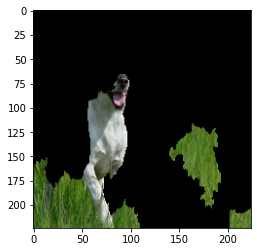

In [ ]:
image, mask = explanation_regnet.get_image_and_mask(
    label=explanation_regnet.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
cropped_image_ndarray = (boundaries).astype(np.uint8)
plt.imshow((boundaries).astype(np.uint8))

In [ ]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, regnet_y_8gf)

Class: Greater_Swiss_Mountain_dog     | Probability: 0.408055
Class: English_springer               | Probability: 0.180911
Class: clumber                        | Probability: 0.033588
Class: Saint_Bernard                  | Probability: 0.021335
Class: American_Staffordshire_terrier | Probability: 0.019004
Class: Great_Dane                     | Probability: 0.017812
Class: English_setter                 | Probability: 0.017482
Class: cocker_spaniel                 | Probability: 0.016296
Class: Brittany_spaniel               | Probability: 0.014966
Class: Appenzeller                    | Probability: 0.013345
Class: basset                         | Probability: 0.011495
Class: Welsh_springer_spaniel         | Probability: 0.011323
Class: Weimaraner                     | Probability: 0.011177
Class: boxer                          | Probability: 0.010965
Class: Labrador_retriever             | Probability: 0.010330


# Zadanie domowe #3

Ponownie zmodyfikuj oryginalny obraz, ale tym razem zaszumiając go w losowy sposób (przykładowa implementacja: https://www.geeksforgeeks.org/add-a-salt-and-pepper-noise-to-an-image-with-python/). Czy najbardziej prawdopodobna klasa zmienia się wraz ze zmianą szumu? Przetestuj dla każdego z modeli.

In [ ]:
import random
import cv2
 
def add_noise(img):
 
    # Getting the dimensions of the image
    row , col = img.shape
     
    # Randomly pick some pixels in the
    # image for coloring them white
    # Pick a random number between 300 and 10000
    number_of_pixels = 200000
    for i in range(number_of_pixels):
       
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
         
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
         
        # Color that pixel to white
        img[y_coord][x_coord] = 255
         
    # Randomly pick some pixels in
    # the image for coloring them black
    # Pick a random number between 300 and 10000
    number_of_pixels = 200000
    for i in range(number_of_pixels):
       
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
         
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
         
        # Color that pixel to black
        img[y_coord][x_coord] = 0
         
    return img

In [ ]:
img = cv2.imread('./data/beagle4.jpg',
                 cv2.IMREAD_GRAYSCALE)

#Storing the image
cv2.imwrite('./data/salt-and-pepper-beagle2.jpg', add_noise(img))

True

In [ ]:
salt_and_pepper_beagle = get_image("./data/salt-and-pepper-beagle2.jpg")

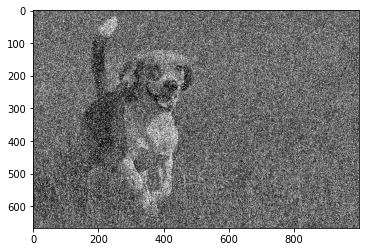

In [ ]:
plt.imshow(salt_and_pepper_beagle)

In [ ]:
explanation_inception = explainer.explain_instance(
    image=lime_transformer(salt_and_pepper_beagle), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
for index in explanation_inception.top_labels:
    print(index_to_label[index])

bloodhound
redbone
black-and-tan_coonhound
bluetick
Weimaraner


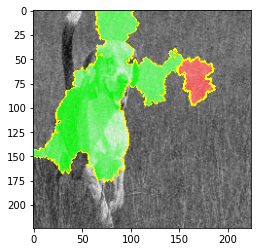

In [ ]:
image, mask = explanation_inception.get_image_and_mask(
    label=explanation_inception.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

In [ ]:
explanation_regnet = explainer.explain_instance(
    image=lime_transformer(salt_and_pepper_beagle), 
    classifier_fn=partial(predict_batch, regnet_y_8gf),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
for index in explanation_regnet.top_labels:
  print(index_to_label[index])

Bedlington_terrier
standard_poodle
fountain
Irish_wolfhound
English_setter


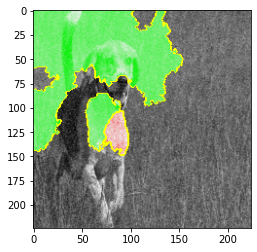

In [ ]:
image, mask = explanation_regnet.get_image_and_mask(
    label=explanation_regnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)